In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import seaborn as sns
import pathlib
import os
import datetime
import random
from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

## Data Preprocessing

#### Download and extract data

In [ ]:
!pip install kaggle --upgrade -q
%env KAGGLE_USERNAME=kevinnguyen2k11
%env KAGGLE_KEY=35fc0c92f00cee8af034c80535d9092d
!kaggle competitions download -c mais-202-winter-2021-kaggle-comp -p /content -q

env: KAGGLE_USERNAME=kevinnguyen2k11
env: KAGGLE_KEY=35fc0c92f00cee8af034c80535d9092d


In [ ]:
!unzip -o -q '*.zip' 
!rm *.zip
train_images = np.load("/content/train_x.npy")
train_labels = np.loadtxt('/content/train_y.csv',delimiter=',',skiprows=1,usecols=1).astype('uint8')
test_images = np.load("/content/test_x.npy")
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1).astype('uint8')
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1).astype('uint8')


2 archives were successfully processed.


#### Define preprocessing function

In [ ]:
# Preprocessing function to extract digits from image data.
# Returns images with pixel values either 1 or 0.

def preprocess(array):
  x = np.copy(array)
  x = np.where(x >= 225, 255, 0).astype('uint8')
  contours = cv.findContours(x, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)[-2]
  contours = sorted(contours, key=cv.contourArea, reverse=True)

  noise = []
  for i in range(3,len(contours)):
    area = cv.contourArea(contours[i])
    x1,y,w,h = cv.boundingRect(contours[i])
    aspect_ratio = float(w)/h    
    rect_area = w*h
    extent = float(area)/rect_area
    # print('area:',area,'aspect:',aspect_ratio,'extent:',extent)
    if (area < 32.5 and aspect_ratio < 2.51 and aspect_ratio > 0.3 and extent > 0.04) or area == 0:
      noise.append(contours[i])
    # else:
    #   print('EXCEPTION')
  
  cv.drawContours(x, noise, -1, 0, 4)
  x = np.where(x == 0, 0, 1)
  return x.reshape(128,128,1).astype('uint8')

#### Expand the dataset by oversampling image classes that occur at low frequency

In [ ]:
# Duplicate low frequency image classes so that every class 
# is in equal proportions.

label_dict = {}
for index in range(len(train_labels)):
  label = train_labels[index]
  if label in label_dict:
    label_dict[label].append(train_images[index])
  else:
    label_dict[label] = [train_images[index]]

expanded_ds = []
expanded_y = []
for i in range(10):
  if i != 9:
    length_quota = len(label_dict[9]) - len(label_dict[i])
    copies = []
    while length_quota > 0:
      index = random.randint(0, len(label_dict[i]) - 1)
      copies.append(label_dict[i][index])
      length_quota -= 1
    copies = np.concatenate((label_dict[i],copies))
  else:
    copies = label_dict[i]
  if i == 0:
    expanded_ds = copies
  else:
    expanded_ds = np.concatenate((expanded_ds,copies))
  expanded_y = np.concatenate((expanded_y,[i]*len(copies)))

combined = list(zip(expanded_ds, expanded_y))
random.shuffle(combined)
expanded_ds, expanded_y = zip(*combined)
expanded_ds = np.array(expanded_ds).astype('uint8')
expanded_y = np.array(expanded_y).astype('uint8')
preprocessed_ds = np.copy(expanded_ds)

#### Preprocess the dataset and create training and validation sets

In [ ]:
batch_size = 16

data_length = len(expanded_ds)
split = round(data_length*0.8)

for i in range(data_length):
  expanded_ds[i] = preprocess(expanded_ds[i])

train_ds = expanded_ds[:split]
val_ds = expanded_ds[split:]

train_y = expanded_y[:split]
val_y = expanded_y[split:]

print("Found {} images.".format(data_length))
print("Using {} images for training, {} images for validation.".format(split, data_length - split))

# test1 = cv.cvtColor(test,cv.COLOR_GRAY2RGB)

Found 107520 images.
Using 86016 images for training, 21504 images for validation.


#### Alternatively, use data generator to apply random transformations

In [ ]:
batch_size = 16

for i in range(len(expanded_ds)):
  expanded_ds[i] = preprocess(expanded_ds[i])

train_img_data_gen = ImageDataGenerator(validation_split=0.2,
                                  #  featurewise_center=True,
                                   samplewise_center=False,
                                  #  featurewise_std_normalization=True,
                                   samplewise_std_normalization=False,
                                   fill_mode='nearest',
                                   rotation_range=20,
                                   width_shift_range=0.09,
                                   height_shift_range=0.09,
                                   shear_range=20,
                                  #  zca_epsilon=0.1,
                                   zca_whitening=False
                                  )

train_img_data_gen.fit(expanded_ds)

train_ds_gen = train_img_data_gen.flow(x=expanded_ds,
                                y=expanded_y,
                                batch_size=batch_size,
                                subset='training',
                                shuffle=True
                              )


val_ds_gen = train_img_data_gen.flow(x=expanded_ds,
                                y=expanded_y,
                                batch_size=batch_size,
                                subset='validation',
                                shuffle=True
                              )

#### Visualize first 3 preprocessed images

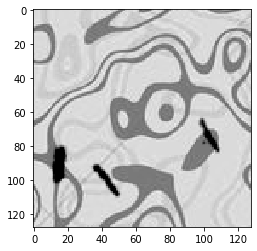

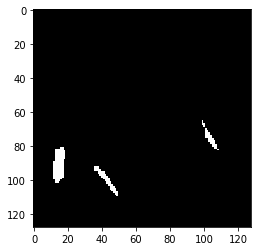

NameError: ignored

In [ ]:
# Shows three stages. From top to bottom, these are original image, 
# thresholded image, and finally image with noise removed using contours.

def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
    plt.show()

def threshold(x):
  x = np.where(x >= 225., 255, 0)
  x = x.astype('uint8')
  return x.reshape(128,128,1)*1./255.

for i in range(3):
  show_image(preprocessed_ds[i])
  show_image(threshold(preprocessed_ds[i]))
  show_image(train_ds[i])

## Create and train model

#### Initialize model layers

In [ ]:
num_classes = 10

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(2048, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Load previously saved model if necessary
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/MAIS/model-best3')

In [ ]:
# Ensure model layers are correct
model.summary()

#### Set learning rate and batch size

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
batch_size = 16

model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['sparse_categorical_accuracy'])

#### Set parameters such as early stopping, learning rate schedule, then train model

In [ ]:
print('Start training:',datetime.datetime.now())

modelPath = '/content/drive/MyDrive/Colab Notebooks/MAIS/6layer-best1'

earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
mcp_save = ModelCheckpoint(modelPath, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

model.fit(
    x=expanded_ds,
    y=expanded_y,
    # validation_data=(val_ds, val_y),
    # validation_data=val_ds_gen,
    epochs=50,
    batch_size=batch_size,
    verbose=1,
    initial_epoch=0,
    max_queue_size=350,
    workers=350,
    use_multiprocessing=False,
    # callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

#### Preprocess test dataset

In [ ]:
test_ds = np.copy(test_images)
for i in range(len(test_ds)):
  test_ds[i] = preprocess(test_ds[i])

#### Generate predictions on test dataset and save to csv file

In [ ]:
print("Evaluate on test data")
results = model.predict(test_ds, verbose=1)
dataframe = {'Id':np.arange(len(results)).astype('uint16'),'Category':np.argmax(results,axis=1).astype('uint8')}
df = pd.DataFrame(dataframe)
df.to_csv('results.csv',index=False)

#### Visualize first 3 test images and predictions then submit to kaggle

In [ ]:
for i in range(len(results,3)):
  print(np.argmax(results[i]))
  show_image(test_images[i])

In [ ]:
!kaggle competitions submit -c mais-202-winter-2021-kaggle-comp -f results1.csv -m "Message"

100% 67.3k/67.3k [00:00<00:00, 321kB/s]
Successfully submitted to MAIS 202 Winter 2021 - Assignment 4

#### Visualize confusion matrix on training set

3360/3360 [==============================] - 25s 8ms/step


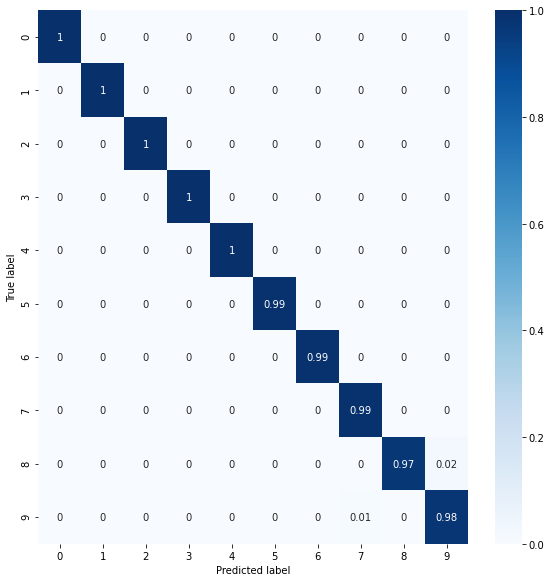

In [ ]:
# Confusion matrix

imgs = expanded_ds
labels = tf.convert_to_tensor(expanded_y)
predictions = model.predict(imgs, verbose=1, max_queue_size=100, workers=80)
predictions_num = [np.argmax(row) for row in predictions]
predictions_num = tf.convert_to_tensor(predictions_num)
classes = [0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions_num, num_classes=10).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()